<a href="https://colab.research.google.com/github/kundajelab/adar_editing/blob/master/xgboost_with_shap/CROSS_SUBSTRATE_TRAINING_XGBOOST_WITH_TREESHAP_TRAIN_NEIL1_AND_AJUBA_PREDICT_TTYH2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install numpy==1.15


In [0]:

## Uncomment these lines if running as a google colab notebook: 
! git clone https://github.com/kundajelab/adar_editing
import os
os.chdir("adar_editing/xgboost_with_shap/")
!pip install shap
!pip install --upgrade xgboost
!pip install cufflinks


In [1]:
%load_ext autoreload
%autoreload 2   

In [2]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))


In [3]:
#helper utilities for model training and interpretation 
import shap
from helpers import * 

#set a random seed so code is reproducible 
random.seed(1234)

# load JS visualization code to notebook
shap.initjs()
import warnings
warnings.filterwarnings('ignore')

#visualization utilities 
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline
import plotly.plotly as py
import numpy as np
from plotly.offline import iplot
from plotly.graph_objs import Heatmap


In [4]:
## Load all the datasets : TTYH2
ttyh2_comp=pd.read_csv("../xin_feature_matrices/ttyh2_computational.features.csv",header=0,sep=',',index_col=0)
#remove any null editing level values 
ttyh2_comp=ttyh2_comp[~ttyh2_comp["editing_value"].isnull().values]
ttyh2_comp=format_for_xgboost(ttyh2_comp)

(601, 216)


In [5]:
## Load all the datasets: NEIL1
neil1_comp=pd.read_csv("../xin_feature_matrices/neil1_computational.features.csv",header=0,sep=',',index_col=0)
#remove any null editing level values 
neil1_comp=neil1_comp[~neil1_comp["editing_value"].isnull().values]
neil1_comp=format_for_xgboost(neil1_comp)

(428, 219)


In [6]:
## Load all the dtasets: AJUBA
ajuba_comp=pd.read_csv("../xin_feature_matrices/ajuba_bc_computational.features.csv",header=0,sep=',',index_col=0)
#remove any null editing level values 
ajuba_comp=ajuba_comp[~ajuba_comp["editing_value"].isnull().values]
ajuba_comp=format_for_xgboost(ajuba_comp)

(482, 186)


In [8]:
train_split,eval_split=split_train_eval_by_mut_pos(ajuba_comp[~ajuba_comp['mut_pos'].isna()])
null_mut_pos=train_split[train_split['mut_pos'].isna()]
train_split=pd.concat((train_split,null_mut_pos),axis=0)

{64.0: 22, 65.0: 21, 66.0: 22, 67.0: 22, 68.0: 22, 69.0: 23, 70.0: 23, 71.0: 24, 72.0: 23, 73.0: 33, 75.0: 33, 76.0: 24, 77.0: 24, 78.0: 23, 79.0: 23, 80.0: 22, 81.0: 22, 82.0: 22, 83.0: 44}


## Train AJUBA, predict NEIL1

In [9]:
test_split=neil1_comp

In [10]:
train_split.reset_index(inplace=True, drop=True) 
eval_split.reset_index(inplace=True,drop=True)
test_split.reset_index(inplace=True,drop=True)

In [11]:
#Remove any non-varying features 
train_novar=get_singleval_features(train_split)
eval_novar=get_singleval_features(eval_split)
test_novar=get_singleval_features(test_split)
uniform_features_to_drop=list(set(train_novar+eval_novar+test_novar))

In [12]:
#Remove any null features 
train_null=get_all_null_features(train_split)
eval_null=get_all_null_features(eval_split)
test_null=get_all_null_features(test_split)
null_features_to_drop=list(set(train_null+eval_null+test_null))

In [13]:
to_drop=list(set(uniform_features_to_drop+null_features_to_drop))
print("\n".join(to_drop))

mut_type:indel
mut_same_as_site
mut_ref_nt:G
u2_length_internal_es
mut_ref_struct:S
d1_5prm_cp_bulge
u1_5prm_cp_bulge:U:A
u3_3prm_cp_bulge:C:G
u3_length_internal_ecs
u1_5prm_cp_internal
mut_ref_nt:A
mut_type:mismatch
d2_5prm_cp_bulge
u3_5prm_cp_internal
site_5prm_cp_bulge:A:U
u2_5prm_cp_internal
mut_ref_nt:U
u3_3prm_cp_internal
d3_5prm_cp_hairpin
u1_3prm_cp_bulge:C:G
u2_exist
d2_3prm_cp_internal:A:U
d2_3prm_cp_internal:G:C
u1_length_hairpin
site_prev_nt:A
mut_type:wt
u1_exist
d2_5prm_cp_hairpin
d1_exist
d1_length_hairpin
d2_exist
u1_length_internal_ecs
mut_ref_struct:I
site_next_nt:A
d3_exist
mut_exist
d1_length_bulge
d2_length_hairpin
u2_3prm_cp_internal
d1_5prm_cp_hairpin
d3_length_hairpin
site_prev_nt:U
u1_3prm_cp_internal
site_5prm_cp_hairpin
d2_3prm_cp_bulge
site_length_hairpin
d2_length_bulge
u2_3prm_cp_bulge:C:G
site_next_nt:U
site_5prm_cp_internal:A:U
u3_exist
d3_5prm_cp_bulge
site_5prm_cp_internal:G:C
u3_5prm_cp_bulge:G:C
u2_length_internal_ecs
u3_length_internal_es
site_3prm_

In [14]:
#remove teh features that don't change across isoforms , or are null for all isoforms
for cur_to_drop in to_drop: 
    try:
        train_split=train_split.drop(cur_to_drop,axis=1)
    except: 
        pass
    try:
        eval_split=eval_split.drop(cur_to_drop,axis=1)
    except: 
        pass 
    try:
        test_split=test_split.drop(to_drop,axis=1)
    except: 
        pass

In [15]:

train_y=train_split['editing_value']
train_X=train_split.drop(['editing_value'],axis=1)
eval_y=eval_split['editing_value']
eval_X=eval_split.drop(['editing_value'],axis=1)
test_y=test_split['editing_value']
test_X=test_split.drop(['editing_value'],axis=1)

In [16]:
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)

(362, 125)
(362,)
(88, 125)
(88,)
(428, 218)
(428,)


In [17]:
train_cols=set(train_X.columns)
eval_cols=set(eval_X.columns)
test_cols=set(test_X.columns)

In [18]:
common=train_cols.intersection(eval_cols)
common=list(common.intersection(test_cols))
print(common)
train_X=train_X[common]
eval_X=eval_X[common]
test_X=test_X[common]
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)

['mut_nt:U', 'u1_length', 'mut_site_dist', 'site_prev_struct:S', 'mut_nt:C', 'd3_length_internal_ecs', 'd2_3prm_cp_internal:U:A', 'u2_length', 'u3_length_stem', 'd3_struct:I', 'u2_struct:S', 'd3_distance', 'd1_length_stem', 'd2_length_internal_es', 'site_5prm_cp_internal:U:G', 'u_hairpin_length', 'site_length_internal_ecs', 'site_length_stem', 'u2_struct:B', 'u2_length_hairpin', 'd2_length', 'mut_nt:G', 'd1_length', 'd3_length', 'site_prev_nt:C', 'site_3prm_cp_internal:G:C', 'u3_distance', 'u3_length', 'u1_length_bulge', 'u1_struct:B', 'site_prev_struct:B', 'free_energy', 'd2_length_stem', 'd1_length_internal_es', 'u1_struct:S', 'u3_length_hairpin', 'site_3prm_cp_internal:C:G', 'u1_3prm_cp_bulge:A:U', 'mut_struct:I', 'site_3prm_cp_bulge:G:C', 'd3_length_stem', 'site_next_nt:C', 'u1_length_stem', 'u3_struct:B', 'site_3prm_cp_internal:A:U', 'all_stem_length', 'd1_struct:S', 'site_5prm_cp_internal:C:G', 'u2_length_stem', 'u2_distance', 'sim_nor_score', 'd2_distance', 'site_1_1:A:G', 'd1_s

In [19]:
## format matrixes for xgboost 
import xgboost
dtrain=xgboost.DMatrix(train_X,train_y)
deval=xgboost.DMatrix(eval_X,eval_y)
dtest=xgboost.DMatrix(test_X,test_y)

In [20]:
## set model training parameters 
from __future__ import unicode_literals
param=dict() 
param['nthread'] = 20
#rmse -- root mean square error 
# mae -- mean absolute error 
# map -- mean average precision 
# auc -- area under ROC curve 
# aucpr -- area under precision recall curve 

#Note: the last metric in your 'eval_metric' list will get optimized 
param['eval_metric'] = ['aucpr','auc','mae','map','rmse']

In [21]:
evallist = [(deval, 'eval'), (dtrain, 'train')]


In [22]:
num_round = 1000
bst = xgboost.train(param, dtrain, num_round, evallist,early_stopping_rounds=10)

[10:07:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[0]	eval-aucpr:0.121462	eval-auc:0.713828	eval-mae:0.324162	eval-map:1	eval-rmse:0.327884	train-aucpr:0.108759	train-auc:0.70515	train-mae:0.324877	train-map:1	train-rmse:0.327549
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[10:07:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1]	eval-aucpr:0.13518	eval-auc:0.715391	eval-mae:0.228502	eval-map:1	eval-rmse:0.230995	train-aucpr:0.12556	train-auc:0.707851	train-mae:0.228021	train-map:1	train-rmse:0.230549
[10:07:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[2]	eval-aucpr:0.144106	eval-auc:0.718345	eval-mae:0.161489	eval-map:1	eval-rmse:0.163717	train-aucpr:0.137951	train-auc:0.710983	

[10:07:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 68 extra nodes, 0 pruned nodes, max_depth=6
[27]	eval-aucpr:0.162829	eval-auc:0.779261	eval-mae:0.012325	eval-map:1	eval-rmse:0.034127	train-aucpr:0.165565	train-auc:0.809177	train-mae:0.002647	train-map:1	train-rmse:0.004095
[10:07:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 22 extra nodes, 0 pruned nodes, max_depth=6
[28]	eval-aucpr:0.162852	eval-auc:0.779448	eval-mae:0.012343	eval-map:1	eval-rmse:0.034134	train-aucpr:0.165578	train-auc:0.809285	train-mae:0.002599	train-map:1	train-rmse:0.004035
[10:07:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 62 extra nodes, 0 pruned nodes, max_depth=6
[29]	eval-aucpr:0.162898	eval-auc:0.779647	eval-mae:0.012294	eval-map:1	eval-rmse:0.034126	train-aucpr:0.165613	train-auc:0.809469	train-mae:0.002443	train-map:1	train-rmse:0.003739
[10:07:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 60 ext

[10:07:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=6
[54]	eval-aucpr:0.152554	eval-auc:0.779188	eval-mae:0.011837	eval-map:1	eval-rmse:0.034335	train-aucpr:0.16613	train-auc:0.810327	train-mae:0.000999	train-map:1	train-rmse:0.001564
[10:07:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[55]	eval-aucpr:0.152543	eval-auc:0.779131	eval-mae:0.011838	eval-map:1	eval-rmse:0.03434	train-aucpr:0.166136	train-auc:0.810337	train-mae:0.000977	train-map:1	train-rmse:0.001547
[10:07:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 58 extra nodes, 0 pruned nodes, max_depth=6
[56]	eval-aucpr:0.152541	eval-auc:0.779147	eval-mae:0.011819	eval-map:1	eval-rmse:0.034332	train-aucpr:0.166142	train-auc:0.810376	train-mae:0.000928	train-map:1	train-rmse:0.001457
[10:07:31] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra

In [23]:
## get model predictions on the test, training, and eval splits 
test_pred = bst.predict(dtest)
train_pred=bst.predict(dtrain)
eval_pred=bst.predict(deval)

In [24]:
## Correlation values 
from scipy.stats import spearmanr,pearsonr
spearman_train=spearmanr(train_y,train_pred)
spearman_eval=spearmanr(eval_y,eval_pred)
spearman_test=spearmanr(test_y,test_pred)

pearson_train=pearsonr(train_y,train_pred)
pearson_eval=pearsonr(eval_y,eval_pred)
pearson_test=pearsonr(test_y,test_pred)

print("Spearman correlation:")
print("Train:"+str(spearman_train))
print("Eval:"+str(spearman_eval))
print("Test:"+str(spearman_test))
print("\n")
print("Pearson correlation:")
print("Train:"+str(pearson_train))
print("Eval:"+str(pearson_eval))
print("Test:"+str(pearson_test))

Spearman correlation:
Train:SpearmanrResult(correlation=0.9976150340879848, pvalue=0.0)
Eval:SpearmanrResult(correlation=0.9093792297106794, pvalue=1.6323535429881429e-34)
Test:SpearmanrResult(correlation=0.4774533661984892, pvalue=9.370228346058991e-26)


Pearson correlation:
Train:(0.9997160403634574, 0.0)
Eval:(0.842061591424685, 8.894755337230594e-25)
Test:(0.5696989309584395, 3.4014175422318606e-38)


In [25]:
## MAE
from sklearn.metrics import mean_absolute_error
mae_train=mean_absolute_error(train_y,train_pred)
print("MAE Train:"+str(mae_train))

mae_eval=mean_absolute_error(eval_y,eval_pred)
print("MAE Eval:"+str(mae_eval))

mae_test=mean_absolute_error(test_y,test_pred)
print("MAE Test:"+str(mae_test))


MAE Train:0.0008434479514429698
MAE Eval:0.011848970868656496
MAE Test:0.19629865933968643


In [26]:
## MAPE
pseudocount=0.01
mape_train=np.mean(np.abs((train_y - train_pred) /(pseudocount+train_y))) * 100
print("MAPE Train:"+str(mape_train)+"%")

mape_eval=np.mean(np.abs((eval_y - eval_pred) /(pseudocount+eval_y))) * 100
print("MAPE Eval:"+str(mape_eval)+"%")

mape_test=np.mean(np.abs((test_y - test_pred) /(pseudocount+test_y))) * 100
print("MAPE Test:"+str(mape_test)+"%")

MAPE Train:2.7251352537890794%
MAPE Eval:19.093296767848024%
MAPE Test:77.61711230190157%


In [27]:
## RMSE
from sklearn.metrics import mean_squared_error
import math 
rmse_train=math.sqrt(mean_squared_error(train_y,train_pred))
print("RMSE Train:"+str(rmse_train))

rmse_eval=math.sqrt(mean_squared_error(eval_y,eval_pred))
print("RMSE Eval:"+str(rmse_eval))

rmse_test=math.sqrt(mean_squared_error(test_y,test_pred))
print("RMSE Test:"+str(rmse_test))


RMSE Train:0.0012887685218270033
RMSE Eval:0.034360948926319995
RMSE Test:0.26839189999352653


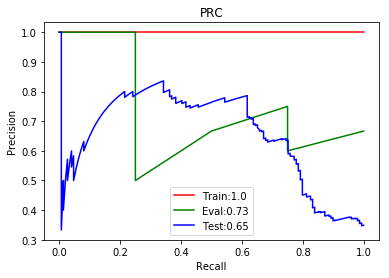

In [30]:
## PRC 
## PRC only valid for binary outcomes. 
## Editing levels < 0.5 are labeled as "0". 
## Editing levels >= 0.5 are labeled as "1". 

from sklearn.metrics import auc, precision_recall_curve

precision_train,recall_train,prc_thresholds_train=precision_recall_curve(train_y>=0.2,train_pred)
precision_eval,recall_eval,prc_thresholds_eval=precision_recall_curve(eval_y>=0.2,eval_pred)
precision_test,recall_test,prc_thresholds_test=precision_recall_curve(test_y>=0.4,test_pred)

auprc_train=auc(recall_train,precision_train)
auprc_eval=auc(recall_eval,precision_eval)
auprc_test=auc(recall_test,precision_test)

plt.plot(recall_train,precision_train,'r',label="Train:"+str(round(auprc_train,2)))
plt.plot(recall_eval,precision_eval,'g',label="Eval:"+str(round(auprc_eval,2)))
plt.plot(recall_test,precision_test,'b',label="Test:"+str(round(auprc_test,2)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PRC")
plt.legend()

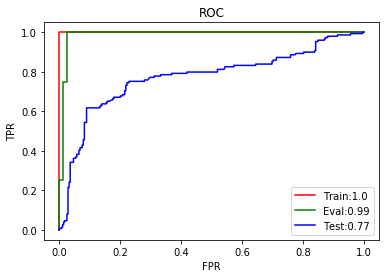

In [34]:
## ROC
from sklearn.metrics import roc_curve, roc_auc_score
fpr_train,tpr_train,roc_thresholds_train=roc_curve(train_y>=0.2,train_pred)
fpr_eval,tpr_eval,roc_thresholds_eval=roc_curve(eval_y>=0.2,eval_pred)
fpr_test,tpr_test,roc_thresholds_test=roc_curve(test_y>=0.4,test_pred)

auroc_train=roc_auc_score(train_y>=0.2,train_pred)
auroc_eval=roc_auc_score(eval_y>=0.2,eval_pred)
auroc_test=roc_auc_score(test_y>=0.4,test_pred)

plt.plot(fpr_train,tpr_train,'r',label="Train:"+str(round(auroc_train,2)))
plt.plot(fpr_eval,tpr_eval,'g',label="Eval:"+str(round(auroc_eval,2)))
plt.plot(fpr_test,tpr_test,'b',label="Test:"+str(round(auroc_test,2)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend()

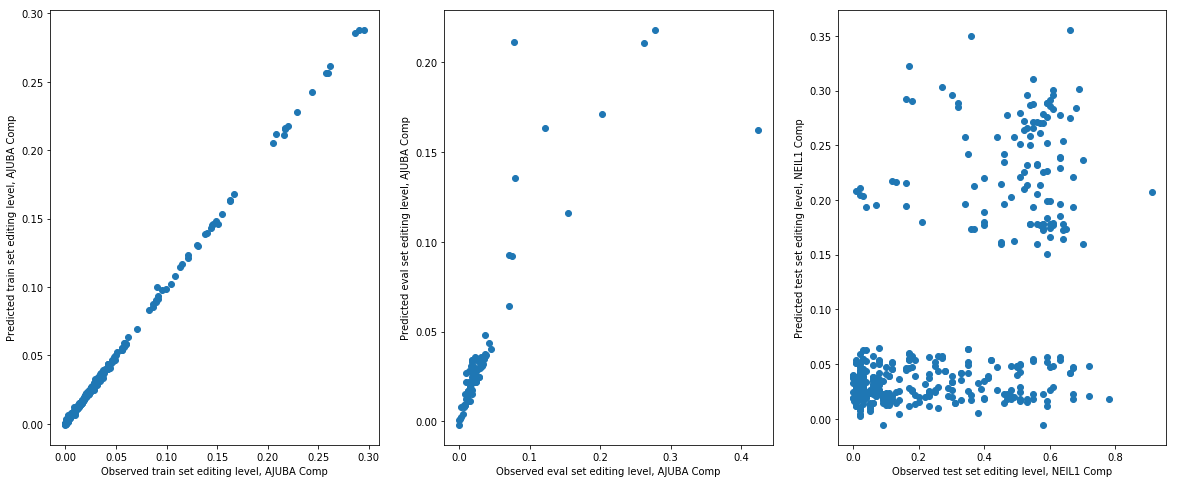

In [35]:
#plot the test set predictions 
matplotlib.rcParams['figure.figsize'] = [20, 8]
plt.subplot(1,3,1)
plt.plot(list(train_y),list(train_pred),'o')
plt.xlabel("Observed train set editing level, AJUBA Comp")
plt.ylabel("Predicted train set editing level, AJUBA Comp")
plt.subplot(1,3,2)
plt.plot(list(eval_y),list(eval_pred),'o')
plt.xlabel("Observed eval set editing level, AJUBA Comp")
plt.ylabel("Predicted eval set editing level, AJUBA Comp")
plt.subplot(1,3,3)
plt.plot(list(test_y),list(test_pred),'o')
plt.xlabel("Observed test set editing level, NEIL1 Comp")
plt.ylabel("Predicted test set editing level, NEIL1 Comp")

plt.show()

## Train AJUBA, predict TTYH2

In [52]:
test_split=ttyh2_comp

In [53]:
train_split.reset_index(inplace=True, drop=True) 
eval_split.reset_index(inplace=True,drop=True)
test_split.reset_index(inplace=True,drop=True)

In [54]:
#Remove any non-varying features 
train_novar=get_singleval_features(train_split)
eval_novar=get_singleval_features(eval_split)
test_novar=get_singleval_features(test_split)
uniform_features_to_drop=list(set(train_novar+eval_novar+test_novar))

In [55]:
#Remove any null features 
train_null=get_all_null_features(train_split)
eval_null=get_all_null_features(eval_split)
test_null=get_all_null_features(test_split)
null_features_to_drop=list(set(train_null+eval_null+test_null))

In [56]:
to_drop=list(set(uniform_features_to_drop+null_features_to_drop))
print("\n".join(to_drop))

u2_length_internal_es
u3_length_internal_ecs
u1_5prm_cp_internal
u3_5prm_cp_internal
u2_5prm_cp_internal
u3_3prm_cp_internal
d3_5prm_cp_hairpin
u2_exist
u1_exist
d2_5prm_cp_hairpin
d1_length_hairpin
d1_exist
d2_exist
u1_length_internal_ecs
d2_length_hairpin
u_hairpin_length
u2_3prm_cp_internal
d1_5prm_cp_hairpin
d3_length_hairpin
u1_3prm_cp_internal
site_5prm_cp_hairpin
site_length_hairpin
u2_length_internal_ecs
u3_length_internal_es
u1_length_internal_es


In [57]:
#remove teh features that don't change across isoforms , or are null for all isoforms
for cur_to_drop in to_drop: 
    try:
        train_split=train_split.drop(cur_to_drop,axis=1)
    except: 
        pass
    try:
        eval_split=eval_split.drop(cur_to_drop,axis=1)
    except: 
        pass 
    try:
        test_split=test_split.drop(to_drop,axis=1)
    except: 
        pass

In [58]:
train_y=train_split['editing_value']
train_X=train_split.drop(['editing_value'],axis=1)
eval_y=eval_split['editing_value']
eval_X=eval_split.drop(['editing_value'],axis=1)
test_y=test_split['editing_value']
test_X=test_split.drop(['editing_value'],axis=1)

In [59]:
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)

(362, 124)
(362,)
(88, 124)
(88,)
(601, 190)
(601,)


In [60]:
train_cols=set(train_X.columns)
eval_cols=set(eval_X.columns)
test_cols=set(test_X.columns)

In [61]:
common=train_cols.intersection(eval_cols)
common=list(common.intersection(test_cols))
print(common)
train_X=train_X[common]
eval_X=eval_X[common]
test_X=test_X[common]
print(train_X.shape)
print(train_y.shape)
print(eval_X.shape)
print(eval_y.shape)
print(test_X.shape)
print(test_y.shape)

['mut_nt:U', 'u1_length', 'mut_site_dist', 'site_prev_struct:S', 'mut_nt:C', 'site_prev_struct:I', 'd3_length_internal_ecs', 'd2_3prm_cp_internal:U:A', 'u2_length', 'd1_5prm_cp_bulge:C:G', 'u3_length_stem', 'd3_struct:I', 'u2_struct:S', 'd3_distance', 'd1_length_stem', 'd2_length_internal_es', 'site_5prm_cp_internal:U:G', 'site_length_internal_ecs', 'site_length_stem', 'u2_struct:B', 'u2_length_hairpin', 'd2_length', 'mut_nt:G', 'd1_length', 'd3_length', 'site_prev_nt:C', 'site_3prm_cp_internal:G:C', 'u3_distance', 'u3_length', 'u1_length_bulge', 'u1_struct:B', 'site_prev_struct:B', 'free_energy', 'd2_length_stem', 'd1_length_internal_es', 'site_prev_nt:G', 'u1_struct:S', 'u3_length_hairpin', 'site_3prm_cp_internal:C:G', 'u1_3prm_cp_bulge:A:U', 'mut_struct:I', 'd1_5prm_cp_internal:A:U', 'site_3prm_cp_bulge:G:C', 'site_5prm_cp_bulge:G:C', 'd3_length_stem', 'site_next_nt:C', 'u1_length_stem', 'u3_struct:B', 'site_3prm_cp_internal:A:U', 'all_stem_length', 'd1_struct:S', 'site_5prm_cp_inte

In [62]:
## format matrixes for xgboost 
import xgboost
dtrain=xgboost.DMatrix(train_X,train_y)
deval=xgboost.DMatrix(eval_X,eval_y)
dtest=xgboost.DMatrix(test_X,test_y)

In [63]:
## set model training parameters 
from __future__ import unicode_literals
param=dict() 
param['nthread'] = 20
#rmse -- root mean square error 
# mae -- mean absolute error 
# map -- mean average precision 
# auc -- area under ROC curve 
# aucpr -- area under precision recall curve 

#Note: the last metric in your 'eval_metric' list will get optimized 
param['eval_metric'] = ['aucpr','auc','mae','map','rmse']

In [64]:
evallist = [(deval, 'eval'), (dtrain, 'train')]


In [65]:
num_round = 1000
bst = xgboost.train(param, dtrain, num_round, evallist,early_stopping_rounds=10)

[10:14:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[0]	eval-aucpr:0.121462	eval-auc:0.713828	eval-mae:0.324162	eval-map:1	eval-rmse:0.327884	train-aucpr:0.108759	train-auc:0.70515	train-mae:0.324877	train-map:1	train-rmse:0.327549
Multiple eval metrics have been passed: 'train-rmse' will be used for early stopping.

Will train until train-rmse hasn't improved in 10 rounds.
[10:14:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[1]	eval-aucpr:0.13518	eval-auc:0.715391	eval-mae:0.228502	eval-map:1	eval-rmse:0.230995	train-aucpr:0.12556	train-auc:0.707851	train-mae:0.228021	train-map:1	train-rmse:0.230549
[10:14:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 8 extra nodes, 0 pruned nodes, max_depth=4
[2]	eval-aucpr:0.144106	eval-auc:0.718345	eval-mae:0.161489	eval-map:1	eval-rmse:0.163717	train-aucpr:0.137951	train-auc:0.710983	

[10:14:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 28 extra nodes, 0 pruned nodes, max_depth=6
[27]	eval-aucpr:0.164893	eval-auc:0.775812	eval-mae:0.012878	eval-map:1	eval-rmse:0.033388	train-aucpr:0.165559	train-auc:0.809109	train-mae:0.002879	train-map:1	train-rmse:0.004392
[10:14:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 50 extra nodes, 0 pruned nodes, max_depth=6
[28]	eval-aucpr:0.164909	eval-auc:0.776018	eval-mae:0.012775	eval-map:1	eval-rmse:0.033365	train-aucpr:0.165602	train-auc:0.809333	train-mae:0.002725	train-map:1	train-rmse:0.004211
[10:14:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 70 extra nodes, 0 pruned nodes, max_depth=6
[29]	eval-aucpr:0.164937	eval-auc:0.776266	eval-mae:0.012739	eval-map:1	eval-rmse:0.033357	train-aucpr:0.165619	train-auc:0.80944	train-mae:0.002576	train-map:1	train-rmse:0.004091
[10:14:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extr

[10:14:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 26 extra nodes, 0 pruned nodes, max_depth=6
[54]	eval-aucpr:0.165251	eval-auc:0.778155	eval-mae:0.012525	eval-map:1	eval-rmse:0.033692	train-aucpr:0.166297	train-auc:0.810378	train-mae:0.000985	train-map:1	train-rmse:0.00147
[10:14:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 54 extra nodes, 0 pruned nodes, max_depth=6
[55]	eval-aucpr:0.165234	eval-auc:0.778011	eval-mae:0.012526	eval-map:1	eval-rmse:0.033698	train-aucpr:0.166309	train-auc:0.810408	train-mae:0.000923	train-map:1	train-rmse:0.00137
[10:14:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 24 extra nodes, 0 pruned nodes, max_depth=6
[56]	eval-aucpr:0.165237	eval-auc:0.778079	eval-mae:0.012511	eval-map:1	eval-rmse:0.033694	train-aucpr:0.166309	train-auc:0.810412	train-mae:0.000908	train-map:1	train-rmse:0.001352
[10:14:43] /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 40 extra

In [66]:
## get model predictions on the test, training, and eval splits 
test_pred = bst.predict(dtest)
train_pred=bst.predict(dtrain)
eval_pred=bst.predict(deval)

In [67]:
## Correlation values 
from scipy.stats import spearmanr,pearsonr
spearman_train=spearmanr(train_y,train_pred)
spearman_eval=spearmanr(eval_y,eval_pred)
spearman_test=spearmanr(test_y,test_pred)

pearson_train=pearsonr(train_y,train_pred)
pearson_eval=pearsonr(eval_y,eval_pred)
pearson_test=pearsonr(test_y,test_pred)

print("Spearman correlation:")
print("Train:"+str(spearman_train))
print("Eval:"+str(spearman_eval))
print("Test:"+str(spearman_test))
print("\n")
print("Pearson correlation:")
print("Train:"+str(pearson_train))
print("Eval:"+str(pearson_eval))
print("Test:"+str(pearson_test))

Spearman correlation:
Train:SpearmanrResult(correlation=0.9980412519510544, pvalue=0.0)
Eval:SpearmanrResult(correlation=0.8746741331874318, pvalue=8.742564968393333e-29)
Test:SpearmanrResult(correlation=0.5010354587121723, pvalue=1.6293235257033377e-39)


Pearson correlation:
Train:(0.999707333289106, 0.0)
Eval:(0.8488914509276778, 1.5463304219156123e-25)
Test:(0.4020119475051999, 9.477188404806343e-25)


In [68]:
## MAE
from sklearn.metrics import mean_absolute_error
mae_train=mean_absolute_error(train_y,train_pred)
print("MAE Train:"+str(mae_train))

mae_eval=mean_absolute_error(eval_y,eval_pred)
print("MAE Eval:"+str(mae_eval))

mae_test=mean_absolute_error(test_y,test_pred)
print("MAE Test:"+str(mae_test))


MAE Train:0.0008785022330347856
MAE Eval:0.012493808138051959
MAE Test:0.11065658926884467


In [69]:
## MAPE
pseudocount=0.01
mape_train=np.mean(np.abs((train_y - train_pred) /(pseudocount+train_y))) * 100
print("MAPE Train:"+str(mape_train)+"%")

mape_eval=np.mean(np.abs((eval_y - eval_pred) /(pseudocount+eval_y))) * 100
print("MAPE Eval:"+str(mape_eval)+"%")

mape_test=np.mean(np.abs((test_y - test_pred) /(pseudocount+test_y))) * 100
print("MAPE Test:"+str(mape_test)+"%")

MAPE Train:2.7794752493725468%
MAPE Eval:21.702101412273013%
MAPE Test:67.92294299120356%


In [70]:
## RMSE
from sklearn.metrics import mean_squared_error
import math 
rmse_train=math.sqrt(mean_squared_error(train_y,train_pred))
print("RMSE Train:"+str(rmse_train))

rmse_eval=math.sqrt(mean_squared_error(eval_y,eval_pred))
print("RMSE Eval:"+str(rmse_eval))

rmse_test=math.sqrt(mean_squared_error(test_y,test_pred))
print("RMSE Test:"+str(rmse_test))


RMSE Train:0.0013097993191314768
RMSE Eval:0.03369461478696661
RMSE Test:0.1566682333227174


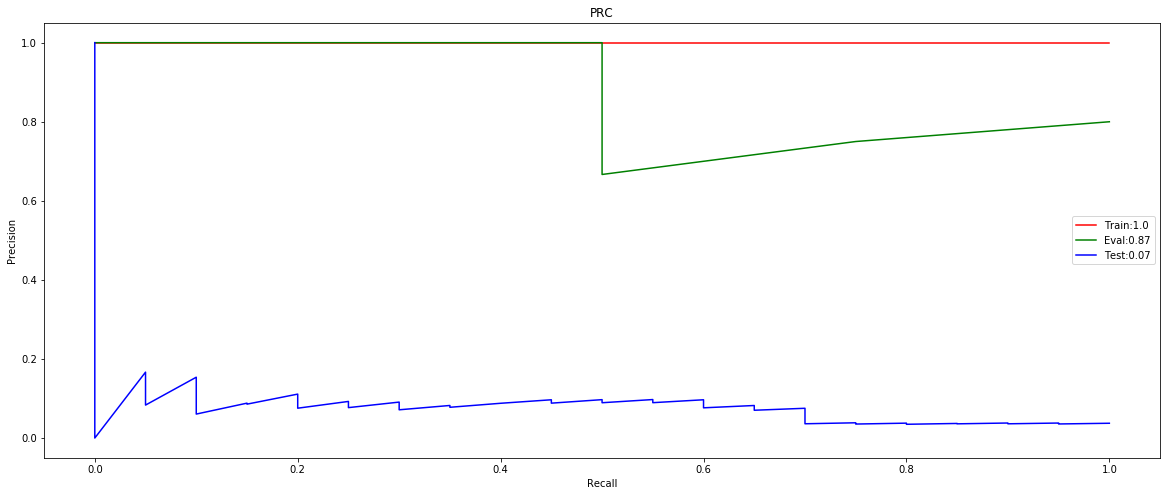

In [74]:
## PRC 
## PRC only valid for binary outcomes. 
## Editing levels < 0.5 are labeled as "0". 
## Editing levels >= 0.5 are labeled as "1". 

from sklearn.metrics import auc, precision_recall_curve

precision_train,recall_train,prc_thresholds_train=precision_recall_curve(train_y>=0.2,train_pred)
precision_eval,recall_eval,prc_thresholds_eval=precision_recall_curve(eval_y>=0.2,eval_pred)
precision_test,recall_test,prc_thresholds_test=precision_recall_curve(test_y>=0.4,test_pred)

auprc_train=auc(recall_train,precision_train)
auprc_eval=auc(recall_eval,precision_eval)
auprc_test=auc(recall_test,precision_test)

plt.plot(recall_train,precision_train,'r',label="Train:"+str(round(auprc_train,2)))
plt.plot(recall_eval,precision_eval,'g',label="Eval:"+str(round(auprc_eval,2)))
plt.plot(recall_test,precision_test,'b',label="Test:"+str(round(auprc_test,2)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PRC")
plt.legend()

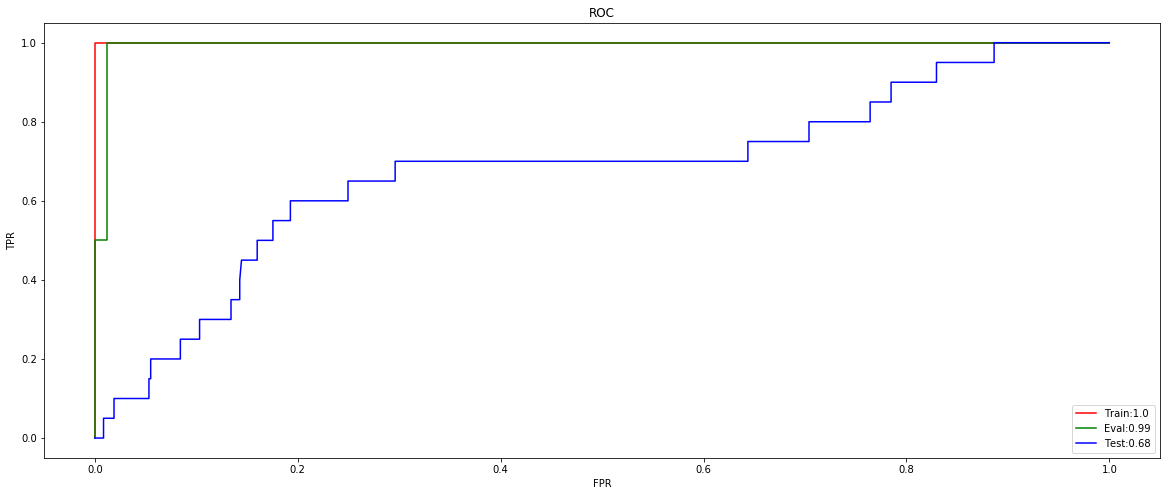

In [75]:
## ROC
from sklearn.metrics import roc_curve, roc_auc_score
fpr_train,tpr_train,roc_thresholds_train=roc_curve(train_y>=0.2,train_pred)
fpr_eval,tpr_eval,roc_thresholds_eval=roc_curve(eval_y>=0.2,eval_pred)
fpr_test,tpr_test,roc_thresholds_test=roc_curve(test_y>=0.4,test_pred)

auroc_train=roc_auc_score(train_y>=0.2,train_pred)
auroc_eval=roc_auc_score(eval_y>=0.2,eval_pred)
auroc_test=roc_auc_score(test_y>=0.4,test_pred)

plt.plot(fpr_train,tpr_train,'r',label="Train:"+str(round(auroc_train,2)))
plt.plot(fpr_eval,tpr_eval,'g',label="Eval:"+str(round(auroc_eval,2)))
plt.plot(fpr_test,tpr_test,'b',label="Test:"+str(round(auroc_test,2)))
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend()

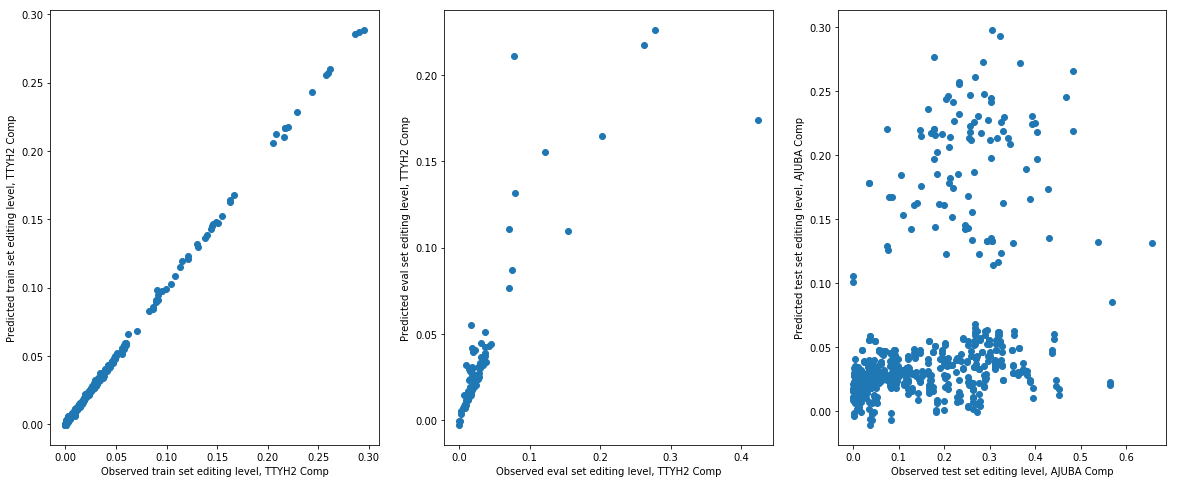

In [76]:
#plot the test set predictions 
matplotlib.rcParams['figure.figsize'] = [20, 8]
plt.subplot(1,3,1)
plt.plot(list(train_y),list(train_pred),'o')
plt.xlabel("Observed train set editing level, TTYH2 Comp")
plt.ylabel("Predicted train set editing level, TTYH2 Comp")
plt.subplot(1,3,2)
plt.plot(list(eval_y),list(eval_pred),'o')
plt.xlabel("Observed eval set editing level, TTYH2 Comp")
plt.ylabel("Predicted eval set editing level, TTYH2 Comp")
plt.subplot(1,3,3)
plt.plot(list(test_y),list(test_pred),'o')
plt.xlabel("Observed test set editing level, AJUBA Comp")
plt.ylabel("Predicted test set editing level, AJUBA Comp")

plt.show()